In [25]:
import random
import requests as rq
from bs4 import BeautifulSoup
import re
import networkx as nx

#clases
class Nodo():
    
    #cuando se incializa un nodo se crea en el grafico, se le da un nombre, la url de su pagina de wikipedia y se le crea una lista con todos los links dentro de ella
    def __init__(self, nombre) -> None:
        self.nombre = nombre
        self.palabras = set()
        self.parsePage(nombre)
    
    #metodo que va a fijarse si dos nodos tienen conexion, osea si uno referencia al otro
    def estaEn(self, nodo):
        if self.nombre.lower() in nodo.palabras:
            self.addEdge(nodo)
            
     
    #metodo que me creo una arista con otro nodo que le pase por parametro       
    def addEdge(self, nodo):
        return (self.nombre, nodo.nombre)
    
    #metodo que me crea el nodo en un grafico
    def createNode(self):
        pass
    
    #parsea con bs4 la pagina de wikipedia que le pases, obteniendo los hipervinculos dentro
    def parsePage(self,nombre):
        pass        
        #el prefijo para siguientes busquedas
        prefijo_wiki = "https://es.wikipedia.org/wiki/"
        
        url = prefijo_wiki + nombre
        #obtengo la pagina 
        page = rq.get(url)

        #la parseo en un objeto
        soup = BeautifulSoup(page.content, "html.parser")
        
        #armo una lista con los terminos que yo quiero, en este caso todos los links que refertencian a otra pagina dentro de la wikipedia
        links = soup.find_all('a', attrs={"href": re.compile("^/wiki/")},limit=200)

        r = re.compile(".*wikipedia")
        newlist = list(filter(r.match, links)) # Read Note below

        #selecciono a partir de que links me va a interesar revisar (es arbitrario para reducir los link que no me importan)
        limite_inferior = 0


        #obtengo el texto y lo cargo en el set
        for i in links[limite_inferior:]:
            self.palabras.add(i.get_text().lower().replace(" ","_"))
            
        
        #remuevo los resultados vacios
        try:
            self.palabras.remove('')
        except KeyError:
            pass
        
        try:
            self.palabras.remove("limitación_de_responsabilidad")
        except KeyError:
            pass
        
        try:
            self.palabras.remove("acerca_de_wikipedia")
        except KeyError:
            pass
        
        try:
            for i in newlist:
                self.palabras.remove(i.lower())
        except KeyError:
            pass
            


# creo dos nodos de prueba
# mamiferos = Nodo("mamiferos")
# x = Nodo("x")

#lista que va a tener todos los nodos del grafico
nodos = list()
# lista que contiene los vertices
vertices = list()

#nodo central
nodo_maestro = Nodo("mamiferos")
# lo agrego a la lista con todos los nodos
nodos.append(nodo_maestro)


# obtengo un nodo aleatorio
nodo = Nodo(list(nodo_maestro.palabras)[random.randrange(0,len(nodo_maestro.palabras))])
nodo_anterior = nodo_maestro

for i in range(100):
    print(nodo.nombre)
    if (len(nodo.palabras)>0):
        vertices.append((nodo_anterior.nombre, nodo.nombre))
        nodo_anterior = nodo
        nodos.append(nodo)
        nodo = Nodo(list(nodo.palabras)[random.randrange(0,len(nodo.palabras))]) # cambiar nodo_maestro por nodo
    else:
        nodo =  Nodo(random.choice(list(nodo_anterior.palabras)))

for i in nodos:
    print(i.nombre)
    


for i in nodos:
    for j in nodos:
        t = i.estaEn(j)
        if t != None:
            vertices.append(t)
        
print(vertices)



grafo = nx.Graph()

grafo.add_nodes_from(nodos)
grafo.add_edges_from(vertices)
nx.draw(grafo)




TypeError: expected string or bytes-like object

filo
jerarquía_linneana
control_de_autoridades
archivística
reprografía
gnd
nkc
aat
siglas
sida
preservativo
poliisopreno
látex
enemas
nkc
apendicitis
parasimpático
wikimedia_commons
wikilibros
wikichicos
categoría
_crítica_de_la_razón_pura
gnd
católico
hechos_de_los_apóstoles
tertuliano
teólogos_cristianos
parís
escuela_normal_superior
mapa_interactivo
1-4129-1313-6
vídeos_digitales
atsc
jamaica
punto_más_alto
parroquia_de_saint_catherine
raggamufin_(ragga)
fondo_monetario_internacional
parroquia_de_hanover
1872
claude_monet
29_de_enero
ayane_sakura
23
veto
control_de_autoridades
archivística
isad(g)
archivística
archivística


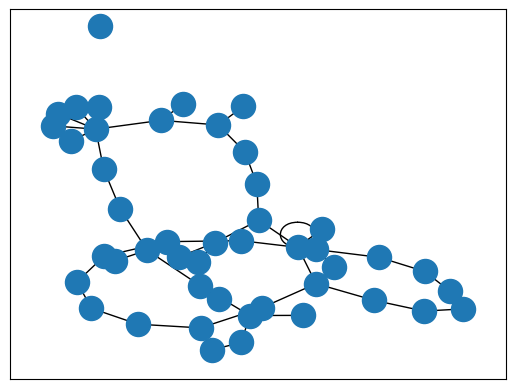

In [39]:
import random
import requests as rq
from bs4 import BeautifulSoup
import re
import networkx as nx

#clases
class Nodo():
    
    #cuando se incializa un nodo se crea en el grafico, se le da un nombre, la url de su pagina de wikipedia y se le crea una lista con todos los links dentro de ella
    def __init__(self, nombre) -> None:
        self.nombre = nombre
        self.palabras = set()
        self.parsePage(nombre)
    
    #metodo que va a fijarse si dos nodos tienen conexion, osea si uno referencia al otro
    def estaEn(self, nodo):
        if self.nombre.lower() in nodo.palabras:
            self.addEdge(nodo)
            
     
    #metodo que me creo una arista con otro nodo que le pase por parametro       
    def addEdge(self, nodo):
        return (self.nombre, nodo.nombre)
    
    #metodo que me crea el nodo en un grafico
    def createNode(self):
        pass
    
    #parsea con bs4 la pagina de wikipedia que le pases, obteniendo los hipervinculos dentro
    def parsePage(self,nombre):
        pass        
        #el prefijo para siguientes busquedas
        prefijo_wiki = "https://es.wikipedia.org/wiki/"
        
        url = prefijo_wiki + nombre
        #obtengo la pagina 
        page = rq.get(url)

        #la parseo en un objeto
        soup = BeautifulSoup(page.content, "html.parser")
        
        #armo una lista con los terminos que yo quiero, en este caso todos los links que refertencian a otra pagina dentro de la wikipedia
        links = soup.find_all('a', attrs={"href": re.compile("^/wiki/")})

        #selecciono a partir de que links me va a interesar revisar (es arbitrario para reducir los link que no me importan)
        limite_inferior = 30


        #obtengo el texto y lo cargo en el set
        for i in links[limite_inferior:]:
            self.palabras.add(i.get_text().lower().replace(" ","_"))

            
        
        #remuevo los resultados vacios
        try:
            self.palabras.remove('')
        except KeyError:
            pass
        
        try:
            self.palabras.remove("limitación_de_responsabilidad")
        except KeyError:
            pass
        
        try:
            self.palabras.remove("acerca_de_wikipedia")
        except KeyError:
            pass
        
        # filtro aquellos resultados que empiezan con wikipedia y lso de isb
        for i in list(self.palabras):
            if re.match(r"^wikipedia", i) or re.match(r"^isbn", i):
                self.palabras.remove(i)
        
            




#lista que va a tener todos los nodos del grafico
nodos = list()
# lista que contiene los vertices
vertices = list()

#nodo central
nodo_maestro = Nodo("mamiferos")
# lo agrego a la lista con todos los nodos
nodos.append(nodo_maestro)


# obtengo un nodo aleatorio
nodo = Nodo(list(nodo_maestro.palabras)[random.randrange(0,len(nodo_maestro.palabras))])
nodo_anterior = nodo_maestro

for i in range(50):
    print(nodo.nombre)
    nodos.append(nodo.nombre)
    vertices.append((nodo_anterior.nombre, nodo.nombre))
    if (len(nodo.palabras)>0):
        nodo_anterior = nodo
        nodo = Nodo(list(nodo_anterior.palabras)[random.randrange(0,len(nodo_anterior.palabras))]) # cambiar nodo_maestro por nodo
    else:
        nodo =  Nodo(random.choice(list(nodo_anterior.palabras)))




grafo = nx.Graph()
nodos = set(nodos)
grafo.add_nodes_from(list(nodos))
grafo.add_edges_from(vertices)
nx.draw_networkx(grafo, with_labels=False)

